In [ ]:
from collections import Counter
from itertools import product
import math
import io
import os
import time
import random

In [ ]:
#PREPROCESSING
def get_ngrams(path, n):
  result = []
  with open(path) as input:
    for line in input:
      if(len(line)<3 or len(line)>16):
        continue
      line = "0" + line
      for i in range(len(line) - (n-1)):
        result.append((line[i:i+n]))
  return result

get_ngrams("tester.txt", 3)


def post_process(input):
  result = []
  for value in input:
    result.append(value[1:-1])
  return result

In [ ]:
#HELPER FUNCTIONS

#turns a 2d matrix into an adjacency list of indeces
def board_to_adjlist(board):
    result = dict()
    for i in range(len(board)):
        for j in range(len(board[0])):
            idx = (i,j)
            neighbors = []
            for x in range(-1,2):
                for y in range(-1,2):
                    if(not(x == 0 and y ==0)):
                        if(x + i >=0 and y + j >=0 and x + i < len(board) and y + j < len(board[0])):
                            neighbors.append((i+x,j+y))
            result[idx] = neighbors
    return result

#turns a 2d matrix into a list of characters
def board_to_list(board):
  result = []
  for row in board:
    result = result + row
  result.sort()
  return result

def board_to_dict(board):
  result = dict()
  for i in range(len(board)):
    for j in range(len(board[0])):
      if(board[i][j] not in result):
        result[board[i][j]] = [(i,j)]
      else:
        result[board[i][j]].append((i,j))
  return result

def exists(word, chars):
  #REQUIRES: char is sorted
  word = list(word)
  word.sort()
  curr = 0
  i = 0
  length = len(chars)
  goal = len(word)
  while(i < length):
    if(curr == goal):
      return True
    if(word[curr] == chars[i]):
      curr +=1
    elif(word[curr] < chars[i]):
      return False
    i +=1
  return curr == goal 

def validate(dictionary, result):
  res = []
  for word in result:
    if(dictionary.get_word(word)):
      res.append(word)
  return res 

## CODE FOR TESTING ##

# prepares the dict of letters to scrabble freqs that we use in the next function
def generate_scrabble_freqs():
  scrabble_freqs = {
      'e': 12.49,
      't':  9.28,
      'a':  8.04,
      'o':  7.64,
      'i':  7.57,
      'n':  7.23,
      's':  6.51,
      'r':  6.28,
      'h':  5.05,
      'l':  4.07,
      'd':  3.82,
      'c':  3.34,
      'u':  2.73,
      'm':  2.51,
      'f':  2.40,
      'p':  2.14,
      'g':  1.87,
      'w':  1.68,
      'y':  1.66,
      'b':  1.48,
      'v':  1.05,
      'k':  0.54,
      'x':  0.23,
      'j':  0.16,
      'q':  0.12,
      'z':  0.09
  }
  scrabble_freqs = dict(sorted(scrabble_freqs.items(), key=lambda x:x[1]))
  index = -1
  preventry = ""
  for entry in scrabble_freqs:
    scrabble_freqs[entry[0]] = round(scrabble_freqs[entry[0]] * 100)
    # if the previous entry exists, add it to the current entry
    if(index >= 0):
      scrabble_freqs[entry[0]] = scrabble_freqs[entry[0]] + scrabble_freqs[preventry]
    index += 1
    preventry = entry[0]
  return scrabble_freqs

#generates number_of_boards boards with dimensions x by y
def generate_random_boards(number_of_boards, x, y):
  letter_freqs = generate_scrabble_freqs()
  boards = []
  for i in range(number_of_boards):
    boards.append([[0]*y for i in range(x)])
    # fill up the board w/random letters
    for j in range(x):
      for k in range(y):
        # generate random letter
        seed = random.randint(0,9998)
        letter = ''
        for l in letter_freqs:
          if(seed <= letter_freqs[l]):
            letter = l
            break
        assert(letter != '')
        boards[i][j][k] = letter.upper()
  return boards

def precision(sols, ref_sols):
  prec = 0
  for word in sols:
    if(word in ref_sols):
      prec += 1
  return prec/len(sols)

def recall(sols, ref_sols):
  rec = 0
  for word in ref_sols:
    if(word in sols):
      rec += 1
  return rec/len(ref_sols)

In [ ]:
generate_random_boards(2,4,4)

[[['D', 'C', 'H', 'E'],
  ['S', 'N', 'N', 'A'],
  ['T', 'T', 'C', 'I'],
  ['D', 'R', 'H', 'D']],
 [['L', 'U', 'N', 'R'],
  ['T', 'A', 'C', 'W'],
  ['T', 'T', 'T', 'T'],
  ['T', 'O', 'I', 'L']]]

# Building a Literal Hash Dictionary

In [ ]:
class Dictionary():
  def __init__(self, path, size):
    self.size = size
    self.book = self.build(path, size)
    self.listed = self.to_list(path)
  
  def build(self, path, size):
    result = dict()
    with open(path) as input:
      for line in input:
        line = line[:-1]
        num = hash(line) % size
        if num in result:
          result[num].append(line)
        else:
          result[num] = [line]
    return result
  
  def to_list(self, path):
    result = []
    with open(path) as input:
      for line in input:
        result.append(line[:-1])
    return result

  def get_word(self, word):
    num = hash(word) % self.size
    return (num in self.book and word in self.book[num])
  






# Building Our N-Gram Language Model

In [ ]:
class LanguageModel():
    def __init__(self, n, train_data, alpha=1):
        """
        Language model class.
        
        Args
        ____
        n: int
            n-gram order
        train_data: List[List]
            list of words in the dictionary that have not been preprocessed yet
        alpha: float
            Smoothing parameter
        
        Other required parameters:
            self.vocab: vocabulary dict with counts
            self.model: n-gram language model, i.e., n-gram dict with probabilties
            self.n_grams_counts: Frequency count for each of the n-grams present in the training data
            self.prefix_counts: Frequency count of all the corresponding n-1 grams present in the training data
        """
        self.n = n
        self.train_data = train_data
        self.tokens = self.train_data
        self.n_grams_counts = None
        self.prefix_counts = None
        self.vocab  = Counter(self.tokens)
        self.alpha = alpha
        self.model = self.build()

    def get_smooth_probabilities(self,n_gram):
      vocab_size = len(self.vocab)
      ngram_sum = self.n_grams_counts[n_gram]

      prefix_sum = len(self.tokens)
      if(self.n>1):
        prefix_sum = self.prefix_counts[n_gram[0:self.n-1]]
        
        

      return (ngram_sum + self.alpha)/(prefix_sum + self.alpha*vocab_size)


      #Returns the smoothed probability of a single ngram, using Laplace Smoothing. Remember to handle the special case of n=1
      #Use the class variables we defined in the build function. It is suggested to implement the build function before this one.

    
    #TODO:
    def build(self):
        
        #Returns a n-gram (could be a unigram) dict with n-gram tuples as keys and probabilities as values. 
        #It could be a unigram model as well
        ngrams = get_ngrams(self.train_data,n=self.n)
        prefix_ngrams = get_ngrams(self.train_data,n = self.n-1)

        self.n_grams_counts = Counter(ngrams)
        self.prefix_counts = Counter(prefix_ngrams)

        prob = dict()
        for n_gram in self.n_grams_counts:
          prob[n_gram] = self.get_smooth_probabilities(n_gram)

        return prob

# Albert: N-Gram Language Model-Based Solver

In [ ]:
class Albert():
  def __init__(self, model,n):
    # I want to pass in a naive bayes n-gram model here.
    #the probability "p" is the parameter we want to train
    self.model = model
    self.p = 0.03
    self.n = n
  
  def check_probability(self, path, next):
    candidate = path[-(self.n-1):] + next
    return (candidate in self.model and self.model[candidate] >= self.p)
  

  def bfs(self, tile, adjlist, board, path, result, visited):
    #INPUT
    #tile : the root tile that we are starting from
    #adjlist : adjacency list of our graph
    #board : 2d matrix of our graph so accessing is easier
    #path : the current accumulated letters for our words
    #pathprob : should we add the log probability of the current path? will do it on second try
    #result : the resulting set from the past
    #visited : the tiles that we have already visited

    #OUTPUT
    #result : the resulting set after conducting bfs

    #check if current path is a word
    if(len(path)>3 and self.check_probability(path, "\n")):
      result.add(path + "\n")

    #check if extensions are a word
    #for each neighbor
    for neighbor in adjlist[tile]:
        #if we haven't visited it yet, we do smth
        #so if we've visited all the neighbors we just move on
        if neighbor not in visited:
            next = str(board[neighbor[0]][neighbor[1]])
            #check probabilities
            if(self.check_probability(path, next)):
              new = path + next
              temp = visited.copy()
              temp.append(neighbor)
              result = result | self.bfs(neighbor, adjlist, board, new, result, temp)
    return result 


  def solve(self, board):
      #INPUT
      # board: a 2-d char array of n x n dimensions
      # cutoff: the probability 0 < cutoff < 1, such that if the probability a character follows is lower than this cutoff we do not pursue this path

      #OUTPUT
      # result: a set of words found from the board

      result = set()

      #first, we want to make an adjacency list
      adjlist = board_to_adjlist(board)
      for tile in adjlist:
        visited = [tile]
        path = "0" + str(board[tile[0]][tile[1]])
        found = self.bfs(tile, adjlist, board,path , set(), visited)
        result = result | found
         
      return post_process(result)
  
  def train(self, boards, solutions):
    #essentially, what we want to do here is solve each board
    #its better to make our probability initially really small so that
    #runtime isn't dogshit (it will take eons to run if we go through every single possible path)
    #then our loss function will be p = p * log (wP/wR) (thinking about adding here, see which one does better), 
    # where wP is the weighted precision and wR is the weighted recall (this is based on wordhunt scores, eg 800 for 5 letter words)
    #we keep going until we go through all the boards and solutions
    #afterwards, print our final p-value to see where it ended up
    return
  

  def evaluate(self, boards):
    # boards: a list of boards (generated by the helper function generate_random_boards)
    # this will contain a a row for every board; each row contains the precision, recall, and f1 of our solution against reference, in that order
    summary_stats = []
    epoch = 0
    for board in boards:
      print("epoch", epoch, ":\n")
      # TODO: FIX THE SYNTAX (ref_sol.solve is 100% not correct)
      ref_sol = ref_sol.solve(board)
      train_sol = self.solve(board)
      # find precision, recall
      prec = self.precision(train_sol, ref_sol)
      rec = self.recall(train_sol, ref_sol)
      f1 = (prec * rec)/(prec + rec)
      print("Precision: ", prec, "Recall: ", rec, "F1", f1)
      summary_stats.append([prec, rec, f1])
    return summary_stats

# Alexei: Albert 2.0
Alexei is also a n-gram based, model, but this time we will look at overall path probability, rather than localized n-gram probability.

In [37]:
class Alexei():
  def __init__(self, path , n, size):
    # I want to pass in a naive bayes n-gram model here.
    #the probability "p" is the parameter we want to train
    lm = LanguageModel(n, path)
    dictionary = Dictionary(path, size)
    self.model = lm.model
    self.p = self.find_cutoffs(dictionary.listed)
    self.n = n
  
  def calculate_logprob(self, word, n):
    word = "0" + word + "\n"
    result = 0
    for i in range(len(word) - (n-1)):
      result += math.log(self.model[word[i:i+n]])
    return result
  
  def find_cutoffs(self, dictionary):
    temp = dict()
    result = dict()
    for word in dictionary:
      if (len(word) in temp):
        temp[len(word)].append(self.calculate_logprob(word, 3))
      else:
        temp[len(word)] = [self.calculate_logprob(word, 3)]
    for length,probabilities in temp.items():
        result[length] = sum(probabilities)/len(probabilities)
    return result
  
  def check_probability(self, path, pathprob, next):
    length = len(path)
    candidate = path[-(self.n-1):] + next
    
    if (candidate in self.model):
      nextprob = math.log(self.model[candidate])
      if (length == 2 or pathprob + nextprob >= self.p[length-1]):
        return nextprob
    return 0
  

  def bfs(self, tile, adjlist, board, path, pathprob, result, visited):
    #INPUT
    #tile : the root tile that we are starting from
    #adjlist : adjacency list of our graph
    #board : 2d matrix of our graph so accessing is easier
    #path : the current accumulated letters for our words
    #pathprob : should we add the log probability of the current path? will do it on second try
    #result : the resulting set from the past
    #visited : the tiles that we have already visited

    #OUTPUT
    #result : the resulting set after conducting bfs

    #check if current path is a word
    if(len(path)>3 and self.check_probability(path, pathprob,"\n")):
      result.add(path + "\n")

    #check if extensions are a word
    #for each neighbor
    for neighbor in adjlist[tile]:
        #if we haven't visited it yet, we do smth
        #so if we've visited all the neighbors we just move on
        if neighbor not in visited:
            next = str(board[neighbor[0]][neighbor[1]])
            #check probabilities
            nextprob = self.check_probability(path, pathprob, next)
            if(nextprob):
              new = path + next
              temp = visited.copy()
              temp.append(neighbor)
              result = result | self.bfs(neighbor, adjlist, board, new, pathprob + nextprob, result, temp)
    return result 


  def solve(self, board):
      #INPUT
      # board: a 2-d char array of n x n dimensions
      # cutoff: the probability 0 < cutoff < 1, such that if the probability a character follows is lower than this cutoff we do not pursue this path

      #OUTPUT
      # result: a set of words found from the board

      result = set()

      #first, we want to make an adjacency list
      adjlist = board_to_adjlist(board)
      for tile in adjlist:
        visited = [tile]
        path = "0" + str(board[tile[0]][tile[1]])
        found = self.bfs(tile, adjlist, board, path , 0, set(), visited)
        result = result | found
         
      return post_process(result)
  
  def train(self, boards, solutions):
    #essentially, what we want to do here is solve each board
    #its better to make our probability initially really small so that
    #runtime isn't dogshit (it will take eons to run if we go through every single possible path)
    #then our loss function will be p = p * log (wP/wR) (thinking about adding here, see which one does better), 
    # where wP is the weighted precision and wR is the weighted recall (this is based on wordhunt scores, eg 800 for 5 letter words)
    #we keep going until we go through all the boards and solutions
    #afterwards, print our final p-value to see where it ended up
    return
  

  def evaluate(self, boards):
    # boards: a list of boards (generated by the helper function generate_random_boards)
    # this will contain a a row for every board; each row contains the precision, recall, and f1 of our solution against reference, in that order
    summary_stats = []
    epoch = 0
    for board in boards:
      print("epoch", epoch, ":\n")
      # TODO: FIX THE SYNTAX (ref_sol.solve is 100% not correct)
      ref_sol = ref_sol.solve(board)
      train_sol = self.solve(board)
      # find precision, recall
      prec = self.precision(train_sol, ref_sol)
      rec = self.recall(train_sol, ref_sol)
      f1 = (prec * rec)/(prec + rec)
      print("Precision: ", prec, "Recall: ", rec, "F1", f1)
      summary_stats.append([prec, rec, f1])
    return summary_stats

# Isaac: Dictionary-Based Solver

In [ ]:
class Isaac():
  def __init__(self, dictionary):
    self.dictionary = dictionary.listed
  

  def dfs(self, word, tile, adjlist, visited, path, board):
    if(path == len(word)):
      return True
    
    for neighbor in adjlist[tile]:
      if neighbor not in visited:
        if board[neighbor[0]][neighbor[1]] == word[path]:
          temp = visited.copy()
          temp.append(neighbor)
          if(self.dfs(word,neighbor, adjlist, temp, path + 1, board)):
            return True

    return False



  def solve(self, board):
    result = []
    adjlist = board_to_adjlist(board)
    lst = board_to_list(board)
    ref = board_to_dict(board)
    #im going to make a dictionary for easy access

    for word in self.dictionary:
      if len(word) > 2 and len(word) <= 16 and exists(word, lst):
        for start in ref[word[0]]:
          if(self.dfs(word, start, adjlist, [start], 1, board)):
            result.append(word)
            break
    return result


# Testing Begins!

In [ ]:

tester = [['A','N','T','E'], ['E','T','A','A'], ['R','D','N','N'], ['L','L','E','K']]

In [ ]:
dictionary = Dictionary("dictionary.txt",10000)

In [ ]:
lm = LanguageModel(3, "dictionary.txt")
albert = Albert(lm.model, 3)

In [41]:
'''
tim = 0
for i in range(100):
  tic = time.perf_counter()
  result = albert.solve(tester)
  result = validate(dictionary, result)
  toc = time.perf_counter()
  tim += (toc - tic)
tim = tim/100
print(tim)
'''
tic = time.perf_counter()
result = albert.solve(tester)
result = sorted(result, key = len, reverse = True)
print(len(result))
result = validate(dictionary, result)
toc = time.perf_counter()
print(toc - tic)
result = sorted(result, key = len, reverse = True)
print(result)
print(len(result))

8606
1.2385074430021632
['ENTENTE', 'ANDANTE', 'TANNATE', 'DENTATE', 'NATTER', 'LENDER', 'NATANT', 'TANNED', 'LENTEN', 'ENATE', 'ANTRE', 'RENTE', 'ENDER', 'REATA', 'TATER', 'EATER', 'ANTED', 'DATER', 'KENTE', 'ENTER', 'EATEN', 'ANTE', 'DATA', 'ANNA', 'TATE', 'DELL', 'LENT', 'RENT', 'DEAN', 'KENT', 'DENT', 'DATE', 'REDE', 'ANTA', 'TENT', 'LEND', 'NANA', 'ELL', 'ANT', 'TED', 'TEN', 'RET', 'ATE', 'ETA', 'DEN', 'END', 'NAN', 'KEN', 'ANE', 'TAN', 'AND', 'DAN', 'DEL', 'LED', 'NET', 'ANA', 'RED']
57


In [38]:
alexei = Alexei("dictionary.txt", 3,10000)

In [43]:
tic = time.perf_counter()
result = alexei.solve(tester)
result = sorted(result, key = len, reverse = True)
print(len(result))
result = validate(dictionary, result)
toc = time.perf_counter()
print(toc - tic)
result = sorted(result, key = len, reverse = True)
print(result)
print(len(result))

1292
0.07530292999945232
['ANTEATER', 'ANTEDATE', 'ANDANTE', 'DENTATE', 'TANNATE', 'ENTENTE', 'NATTER', 'TANKED', 'LENDER', 'NATANT', 'TEATED', 'TANNED', 'LENTEN', 'REDATE', 'EATER', 'ENATE', 'ELDER', 'ANTED', 'DATER', 'KENTE', 'ANTRE', 'KNELL', 'REATA', 'RENTE', 'TATER', 'ENDER', 'REDAN', 'ENTER', 'DELL', 'LENT', 'RENT', 'DATE', 'TENT', 'ANTE', 'DEAN', 'REDE', 'KENT', 'ANTA', 'TANK', 'TATE', 'LEND', 'DENT', 'DAN', 'ELD', 'END', 'NAN', 'ELL', 'TEN', 'DEL', 'LED', 'NET', 'KEN', 'ANA', 'ANE', 'TAN', 'RET', 'ANT', 'AND', 'RED', 'ATE', 'DEN', 'TAT', 'TED']
63


In [ ]:
isaac = Isaac(dictionary)

In [42]:
tic = time.perf_counter()
result = isaac.solve(tester)
result = sorted(result, key = len, reverse = True)
print(len(result))
result = validate(dictionary, result)
toc = time.perf_counter()
print(toc - tic)
result = sorted(result, key = len, reverse = True)
print(result)
print(len(result))

87
0.49203074099932564
['ANTEATER', 'ANTEDATE', 'EDENTATE', 'ANDANTE', 'DENTATE', 'ENTENTE', 'TANNATE', 'ADNATE', 'ANANKE', 'LENDER', 'LENTEN', 'NATANT', 'NATTER', 'REDATE', 'TANKED', 'TANNED', 'TEATED', 'ANENT', 'ANTAE', 'ANTED', 'ANTRE', 'DATER', 'EATEN', 'EATER', 'ELDER', 'ENATE', 'ENDER', 'ENTER', 'KENTE', 'KNELL', 'REATA', 'REDAN', 'RENTE', 'TATER', 'ANNA', 'ANTA', 'ANTE', 'DANK', 'DATA', 'DATE', 'DEAN', 'DELL', 'DENT', 'ETNA', 'KENT', 'LEND', 'LENT', 'NAAN', 'NANA', 'NEAT', 'NERD', 'NETT', 'REDE', 'RENT', 'TANK', 'TATE', 'TEAT', 'TENT', 'ANA', 'AND', 'ANE', 'ANT', 'ATE', 'ATT', 'DAN', 'DEL', 'DEN', 'EAT', 'ELD', 'ELL', 'END', 'ETA', 'KEN', 'LED', 'LEK', 'NAE', 'NAN', 'NET', 'RED', 'RET', 'TAD', 'TAE', 'TAN', 'TAT', 'TEA', 'TED', 'TEN']
87


I explore the relationship between probability and word length here.

In [ ]:
#idk what this is but im gonna try it
def calculate_logprob(word, n):
  word = "0" + word + "\n"
  result = 0
  for i in range(len(word) - (n-1)):
    result += math.log(lm.model[word[i:i+n]])
  return result

temp = dict()
result = dict()
for word in dictionary.listed:
  if (len(word) in temp):
    temp[len(word)].append(calculate_logprob(word, 3))
  else:
    temp[len(word)] = [calculate_logprob(word, 3)]
for length,probabilities in temp.items():
    result[length] = sum(probabilities)/len(probabilities)
print(result)



  


{2: -6.414554690303605, 3: -8.604237692845928, 5: -11.882632491842879, 6: -13.657852758752027, 4: -10.181407818829243, 8: -17.353987041081496, 9: -19.168973224840833, 10: -20.713177139715725, 7: -15.361038521793596, 11: -22.387239925257386, 12: -24.11778948221498, 13: -25.859070851168124, 14: -27.60361337652588, 15: -29.336418250737132}


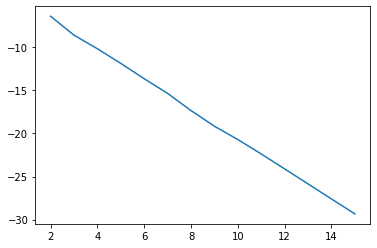

In [ ]:
import matplotlib.pylab as plt

lists = sorted(result.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()

# MASS TESTING
The idea here is we're going to generate a bunch of random boards and solve each one. We will first evaluate on a few easy metrics that we have already looked at previously


1.   Number Correct/Number Total
2.   Number Correct/Number Generated
3.   Time to Generate



In [44]:
def test(n):
  #summary statistics of albert
  albert_precision = 0
  albert_acc = 0
  albert_time = 0
  #summary statistics of alexei
  alexei_precision = 0
  alexei_acc = 0
  alexei_time = 0
  #summary statistics of isaac
  isaac_precision = 1
  isaac_acc = 1
  isaac_time = 0 

  batch = generate_random_boards(n,4,4)
  for board in batch:

    #TESTING FOR ISAAC - OUR CONTROL SOLUTION
    tic = time.perf_counter()
    isaac_res = isaac.solve(board)
    toc = time.perf_counter()
    isaac_time += (toc - tic)
    refsol = len(isaac_res)


    #TESTING FOR ALBERT - OUR FIRST VERSION
    tic = time.perf_counter()
    albert_res = albert.solve(board)
    tot_albert = len(albert_res)
    albert_res = validate(dictionary, albert_res)
    red_albert = len(albert_res)
    toc = time.perf_counter()
    albert_time += (toc - tic)
    albert_precision += red_albert/tot_albert
    albert_acc += red_albert/refsol


    #TESTING FOR ALEXEI - OUR SECOND VERSION
    tic = time.perf_counter()
    alexei_res = alexei.solve(board)
    tot_alexei = len(alexei_res)
    alexei_res = validate(dictionary, alexei_res)
    red_alexei = len(alexei_res)
    toc = time.perf_counter()
    alexei_time += (toc - tic)
    alexei_precision += red_alexei/tot_alexei
    alexei_acc += red_alexei/refsol
    
  #printing the final statistics
  print("FINAL SUMMARY STATISTICS")
  print("########################")
  print("ISAAC REFERENCE STATISTICS")
  print("ISAAC NUMBER CORRECT/NUMBER TOTAL: {}".format(isaac_precision))
  print("ISAAC NUMBER CORRECT/NUMBER GENERATED: {}".format(isaac_acc))
  print("ISAAC AVERAGE TIME TO SOLVE: {}".format(isaac_time/n))
  print("~~~~~~~~~~~~~~~~~~~~~~~~~~~")
  print("ALBERT REFERENCE STATISTICS")
  print("ALBERT NUMBER CORRECT/NUMBER TOTAL: {}".format(albert_precision/n))
  print("ALBERT NUMBER CORRECT/NUMBER GENERATED: {}".format(albert_acc/n))
  print("ALBERT AVERAGE TIME TO SOLVE: {}".format(albert_time/n))
  print("~~~~~~~~~~~~~~~~~~~~~~~~~~~")
  print("ALEXEI REFERENCE STATISTICS")
  print("ALEXEI NUMBER CORRECT/NUMBER TOTAL: {}".format(alexei_precision/n))
  print("ALEXEI NUMBER CORRECT/NUMBER GENERATED: {}".format(alexei_acc/n))
  print("ALEXEI AVERAGE TIME TO SOLVE: {}".format(alexei_time/n))





In [47]:
test(100)

FINAL SUMMARY STATISTICS
########################
ISAAC REFERENCE STATISTICS
ISAAC NUMBER CORRECT/NUMBER TOTAL: 1
ISAAC NUMBER CORRECT/NUMBER GENERATED: 1
ISAAC AVERAGE TIME TO SOLVE: 0.42252371575017605
~~~~~~~~~~~~~~~~~~~~~~~~~~~
ALBERT REFERENCE STATISTICS
ALBERT NUMBER CORRECT/NUMBER TOTAL: 0.06183175207702251
ALBERT NUMBER CORRECT/NUMBER GENERATED: 0.45496053016798876
ALBERT AVERAGE TIME TO SOLVE: 0.09361850172004779
~~~~~~~~~~~~~~~~~~~~~~~~~~~
ALEXEI REFERENCE STATISTICS
ALEXEI NUMBER CORRECT/NUMBER TOTAL: 0.18300540722741712
ALEXEI NUMBER CORRECT/NUMBER GENERATED: 0.5073200886783271
ALEXEI AVERAGE TIME TO SOLVE: 0.015043038050134783
